In [1]:
import scipy.io
import numpy as np
import pandas as pd

In [2]:
mat_data = scipy.io.loadmat('wiki_test.mat')

wiki_data = mat_data['wiki'][0, 0]

data_dict = {
    'dob': wiki_data['dob'][0],
    'photo_taken': wiki_data['photo_taken'][0],
    'full_path': wiki_data['full_path'][0],
    'gender': wiki_data['gender'][0],
    'name': wiki_data['name'][0],
    'face_location': wiki_data['face_location'][0],
    'face_score': wiki_data['face_score'][0],
    'second_face_score': wiki_data['second_face_score'][0],
    'age': wiki_data['age'][0]
}

df = pd.DataFrame(data_dict)

df = df[['age', 'gender', 'full_path']]
df['full_path'] = df['full_path'].str[0]
df['full_path'] = 'wiki_crop/' + df['full_path']

df = df.dropna()

print(df)

       age  gender                                  full_path
0       28     1.0  wiki_crop/17/10000217_1981-05-05_2009.jpg
1       39     1.0  wiki_crop/48/10000548_1925-04-04_1964.jpg
2       59     1.0    wiki_crop/12/100012_1948-07-03_2008.jpg
3       31     1.0  wiki_crop/65/10001965_1930-05-23_1961.jpg
4       41     0.0  wiki_crop/16/10002116_1971-05-31_2012.jpg
...    ...     ...                                        ...
62323   26     1.0   wiki_crop/49/9996949_1937-04-17_1963.jpg
62324   22     1.0   wiki_crop/32/9997032_1947-07-30_1970.jpg
62325   40     1.0   wiki_crop/09/9998109_1972-12-27_2013.jpg
62326   29     1.0   wiki_crop/00/9999400_1981-12-13_2011.jpg
62327   54     0.0    wiki_crop/80/999980_1954-06-11_2008.jpg

[59685 rows x 3 columns]


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.color import rgb2gray
from joblib import Parallel, delayed

In [4]:
# resizing + HOG feature extraction
def extract_hog_features(path, target_size=(128, 128)):
    try:
        img = imread(path)
        img = resize(img, target_size, anti_aliasing=True)
        if len(img.shape) > 2: 
            img = rgb2gray(img)
        # HOG Feature Extraction
        features = hog(img, 
                      orientations=8, 
                      pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), 
                      visualize=False,
                      channel_axis=None)
        return features
    except Exception as e:
        print(f"Error processing {path}: {str(e)}")
        return None

# Parallel HOG feature extraction for speed
print("Extracting HOG features in parallel...")
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(extract_hog_features)(path) for path in df['full_path']
)

# Only include valid/processed images
valid_features = []
valid_indices = []
for i, feat in enumerate(results):
    if feat is not None:
        valid_features.append(feat)
        valid_indices.append(i)

valid_df = df.iloc[valid_indices].copy()
x = np.array(valid_features)
y_age = valid_df['age'].values
y_gender = valid_df['gender'].values

# Train-test split - 80% Training
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    x, y_age, y_gender, test_size=0.2, random_state=42
)

Extracting HOG features in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19140249708688414s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09761404991149902s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 115 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elap

In [5]:
print(X_train.shape)

(47747, 512)


In [6]:
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import r2_score

# Age model
print("\nTraining age model...")
age_model = LinearRegression()
age_model.fit(X_train, y_age_train)
age_pred = age_model.predict(X_test)
print(f"Age MAE: {mean_absolute_error(y_age_test, age_pred):.2f} years")
print(f"Age RMSE: {mean_squared_error(y_age_test, age_pred)**0.5:.2f} years")
print(f"Age R²: {r2_score(y_age_test, age_pred):.2f}")

# KNN for Age
age_knn = KNeighborsRegressor(n_neighbors=5)
age_knn.fit(X_train, y_age_train)
age_knn_pred = age_knn.predict(X_test)
print(f"KNN Age MAE: {mean_absolute_error(y_age_test, age_knn_pred):.2f} years")
print(f"KNN Age RMSE: {mean_squared_error(y_age_test, age_knn_pred)**0.5:.2f} years")
print(f"Age R²: {r2_score(y_age_test, age_knn_pred):.2f}")

# # MLP for Age
# age_mlp = MLPRegressor(hidden_layer_sizes=(64, 32), 
#                       activation='relu', 
#                       solver='adam', 
#                       max_iter=100, 
#                       random_state=42)
# age_mlp.fit(X_train, y_age_train)
# age_mlp_pred = age_mlp.predict(X_test)
# print(f"MLP Age MAE: {mean_absolute_error(y_age_test, age_mlp_pred):.2f} years")
# print(f"MLP Age RMSE: {mean_squared_error(y_age_test, age_mlp_pred)**0.5:.2f} years")
# print(f"Age R²: {r2_score(y_age_test, age_mlp_pred):.2f}")
# MLP for Age
age_mlp = MLPRegressor(hidden_layer_sizes=(100,), 
                        activation='relu', 
                        solver='adam', 
                        max_iter=200, # 100 usually
                        alpha=0.01,
                        batch_size=64,
                        early_stopping=True,
                        random_state=42)
age_mlp.fit(X_train, y_age_train)
age_mlp_pred = age_mlp.predict(X_test)
print(f"MLP Age MAE: {mean_absolute_error(y_age_test, age_mlp_pred):.2f} years")
print(f"MLP Age RMSE: {mean_squared_error(y_age_test, age_mlp_pred)**0.5:.2f} years")
print(f"Age R²: {r2_score(y_age_test, age_mlp_pred):.2f}")

# Gender model
print("\nTraining gender model...")
gender_model = LogisticRegression(max_iter=100)
gender_model.fit(X_train, y_gender_train)
gender_pred = gender_model.predict(X_test)
print(f"Gender accuracy: {accuracy_score(y_gender_test, gender_pred):.2f}")

# KNN for Gender
gender_knn = KNeighborsClassifier(n_neighbors=8)
gender_knn.fit(X_train, y_gender_train)
gender_knn_pred = gender_knn.predict(X_test)
print(f"KNN Gender accuracy: {accuracy_score(y_gender_test, gender_knn_pred):.2f}")

# # MLP for Gender
# gender_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), 
#                           activation='relu', 
#                           solver='adam', 
#                           max_iter=100, 
#                           random_state=42)
# gender_mlp.fit(X_train, y_gender_train)
# gender_mlp_pred = gender_mlp.predict(X_test)
# print(f"MLP Gender accuracy: {accuracy_score(y_gender_test, gender_mlp_pred):.2f}")# MLP for Gender
gender_mlp = MLPClassifier(hidden_layer_sizes=(100,), 
                        activation='relu', 
                        solver='adam', 
                        max_iter=100, 
                        alpha=0.01,
                        batch_size=64,
                        early_stopping=True,
                        random_state=42)
gender_mlp.fit(X_train, y_gender_train)
gender_mlp_pred = gender_mlp.predict(X_test)
print(f"MLP Gender accuracy: {accuracy_score(y_gender_test, gender_mlp_pred):.2f}")


Training age model...
Age MAE: 13.65 years
Age RMSE: 23.28 years
Age R²: 0.10
KNN Age MAE: 15.33 years
KNN Age RMSE: 25.27 years
Age R²: -0.06
MLP Age MAE: 13.20 years
MLP Age RMSE: 22.95 years
Age R²: 0.13

Training gender model...


c:\Users\danie\OneDrive\Desktop\last\334\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gender accuracy: 0.85
KNN Gender accuracy: 0.83
MLP Gender accuracy: 0.86


In [7]:
import time
import json

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score

def eval_searchcv(clfName, clf, clfGrid,
                  xTrain, yTrain, xTest, yTest,
                  perfDict, rocDF, bestParamDict):
    # evaluate grid search and add to perfDict
    cls_perf, cls_roc, gs_p  = eval_gridsearch(clf, clfGrid, xTrain,
                                               yTrain, xTest, yTest)
    perfDict[clfName + " (Grid)"] = cls_perf
    # add to ROC DF
    rocRes = pd.DataFrame(cls_roc)
    rocRes["model"] = clfName
    rocDF = pd.concat([rocDF, rocRes], ignore_index=True)
    # evaluate random search and add to perfDict
    bestParamDict[clfName] = {"Grid": gs_p}
    return perfDict, rocDF, bestParamDict

def eval_gridsearch(clf, pgrid, xTrain, yTrain, xTest, yTest):

    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=pgrid, cv=5, scoring='roc_auc')
    grid.fit(xTrain, yTrain)
    
    best_clf = grid.best_estimator_
    best_clf.fit(xTrain, yTrain)
    
    yProb = best_clf.predict_proba(xTest)[:, 1]
    yPred = best_clf.predict(xTest)
    
    fpr, tpr, _ = roc_curve(yTest, yProb)
    roc_auc = auc(fpr, tpr)
    auprc = average_precision_score(yTest, yProb)
    f1 = f1_score(yTest, yPred)
    
    timeElapsed = time.time() - start
    
    resultDict = {
        "AUC": roc_auc,
        "AUPRC": auprc,
        "F1": f1,
        "Time": timeElapsed
    }
    
    roc = {
        "fpr": fpr,
        "tpr": tpr
    }
    
    bestParams = grid.best_params_
    
    return resultDict, roc, bestParams

def get_parameter_grid(mName):

    if mName == "LR (None)":
        pGrid = {
            'penalty': [None], 
            'solver': ['lbfgs'],
            'max_iter': [100]
        }
    elif mName == "KNN":
        pGrid = {
            'n_neighbors': [8],
            'metric': ['euclidean']
        }
    elif mName == "NN":
        pGrid = {
            # 'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
            'hidden_layer_sizes': [(100,)],
            'activation': ['relu'],
            # 'alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 regularization
            # 'alpha': [0.001, 0.01],  # L2 regularization
            'alpha': [0.01],  # L2 regularization
            # 'learning_rate': ['constant', 'adaptive'],
            # 'learning_rate_init': [0.001, 0.01],
            'batch_size': [64],
            'max_iter': [100],
            'early_stopping': [True],
            'solver': ['adam']
        }
    
    return pGrid


perfDict = {}
rocDF = pd.DataFrame()
bestParamDict = {}

unregLrName = "LR (None)"
unregLrGrid = get_parameter_grid(unregLrName)
perfDict, rocDF, bestParamDict = eval_searchcv(unregLrName, gender_model, unregLrGrid,
                                                X_train, y_gender_train, X_test, y_gender_test,
                                                perfDict, rocDF, bestParamDict)

nnName = "NN"
nnGrid = get_parameter_grid(nnName)
perfDict, rocDF, bestParamDict = eval_searchcv(nnName, gender_mlp, nnGrid,
                                                X_train, y_gender_train, X_test, y_gender_test,
                                                perfDict, rocDF, bestParamDict)

knnGenderName = "KNN"
knnGenderGrid = get_parameter_grid(knnGenderName)
perfDict, rocDF, bestParamDict = eval_searchcv(knnGenderName, gender_knn, knnGenderGrid,
                                                X_train, y_gender_train, X_test, y_gender_test,
                                                perfDict, rocDF, bestParamDict)

perfDF = pd.DataFrame.from_dict(perfDict, orient='index')
print(perfDF)
rocDF.to_csv('rocOutput_hog.csv', index=False)
with open('bestParams_hog.json', 'w') as f:
    json.dump(bestParamDict, f)


c:\Users\danie\OneDrive\Desktop\last\334\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\danie\OneDrive\Desktop\last\334\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

                       AUC     AUPRC        F1        Time
LR (None) (Grid)  0.813699  0.926934  0.909557   11.112772
NN (Grid)         0.843828  0.942403  0.917511  552.187449
KNN (Grid)        0.736562  0.880894  0.898320   22.585896


C:\Users\danie\AppData\Local\Temp\ipykernel_13656\883997015.py:124: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(model_data['tpr'], model_data['fpr'])
C:\Users\danie\AppData\Local\Temp\ipykernel_13656\883997015.py:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_model1 = np.trapz(model1_tpr, model1_fpr)
C:\Users\danie\AppData\Local\Temp\ipykernel_13656\883997015.py:144: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_model2 = np.trapz(model2_tpr, model2_fpr)
C:\Users\danie\AppData\Local\Temp\ipykernel_13656\883997015.py:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_model3 = np.trapz(model3_tp

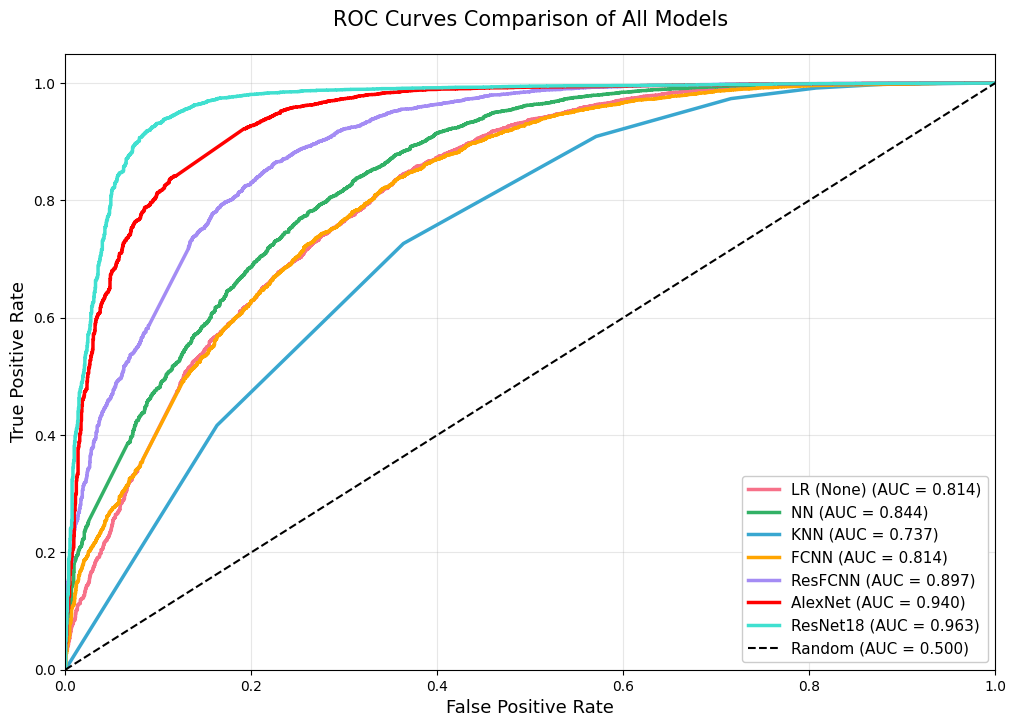

In [8]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the ROC data
# roc_data = pd.read_csv('rocOutput_hog.csv')

# # Calculate AUC for each model
# auc_values = {}
# for model in roc_data['model'].unique():
#     model_data = roc_data[roc_data['model'] == model]
#     auc = np.trapz(model_data['tpr'], model_data['fpr'])
#     auc_values[model] = auc

# # Create the plot
# plt.figure(figsize=(10, 8))

# # Set a color palette
# palette = sns.color_palette("husl", len(roc_data['model'].unique()))

# # Plot ROC curve for each model
# for i, model in enumerate(roc_data['model'].unique()):
#     model_data = roc_data[roc_data['model'] == model]
#     plt.plot(model_data['fpr'], model_data['tpr'], 
#              color=palette[i],
#              linewidth=2,
#              label=f'{model} (AUC = {auc_values[model]:.3f})')

# # Add labels and title
# plt.xlabel('False Positive Rate', fontsize=12)
# plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('ROC Curves Comparison', fontsize=14)

# # Add diagonal line for reference
# plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

# # Add legend
# plt.legend(fontsize=10, loc='lower right')

# # Set limits and grid
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.grid(True, alpha=0.3)


# # Load the Excel file
# file_path = 'roc_res_fcnn.xlsx'
# roc_data = pd.read_excel(file_path, header=None, engine='openpyxl')

# # Extract FPR/TPR for each model and convert to numeric
# model1_fpr = pd.to_numeric(roc_data.iloc[:, 0], errors='coerce').dropna()
# model1_tpr = pd.to_numeric(roc_data.iloc[:, 1], errors='coerce').dropna()

# model2_fpr = pd.to_numeric(roc_data.iloc[:, 2], errors='coerce').dropna()
# model2_tpr = pd.to_numeric(roc_data.iloc[:, 3], errors='coerce').dropna()

# # Calculate AUC separately
# auc_model1 = np.trapz(model1_tpr, model1_fpr)
# auc_model2 = np.trapz(model2_tpr, model2_fpr)

# # Plotting
# plt.figure(figsize=(10, 8))
# palette = sns.color_palette("husl", 8)

# # Plot Model 1
# plt.plot(model1_fpr, model1_tpr, 
#          color='orange',
#          linewidth=2,
#          label=f'FCNN (AUC = {auc_model1:.3f})')

# # Plot Model 2
# plt.plot(model2_fpr, model2_tpr, 
#          color=palette[6],
#          linewidth=2,
#          label=f'ResFCNN (AUC = {auc_model2:.3f})')

# # Add labels, title, and reference line
# plt.xlabel('False Positive Rate', fontsize=12)
# plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('ROC Curves Comparison', fontsize=14)
# plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
# plt.legend(fontsize=10, loc='lower right')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.grid(True, alpha=0.3)

# plt.savefig('roc_curves_comparison6.png', dpi=300, bbox_inches='tight')
# plt.show()








import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure
plt.figure(figsize=(12, 8))

palette = sns.color_palette("husl", 8)  # Returns a list of RGB tuples

colors = {
    'LR (None)': palette[0],
    'KNN': palette[5],
    'NN': palette[3],
    'FCNN': 'orange',
    'ResFCNN': palette[6],
    'Alex': 'red',
    'ResNet18 (CNN)': 'turquoise'
}

# --- First dataset (HOG features) ---
roc_data_hog = pd.read_csv('rocOutput_hog.csv')

# Calculate AUC and plot for each model in HOG dataset
for model in roc_data_hog['model'].unique():
    model_data = roc_data_hog[roc_data_hog['model'] == model]
    auc = np.trapz(model_data['tpr'], model_data['fpr'])
    plt.plot(model_data['fpr'], model_data['tpr'], 
             color=colors.get(model, 'gray'),  # Default to gray if color not specified
             linewidth=2.5,
             label=f'{model} (AUC = {auc:.3f})')

# --- Second dataset (FCNN) ---
roc_data_fcnn = pd.read_excel('roc_res_fcnn.xlsx', header=None, engine='openpyxl')

# Extract and plot FCNN models
model1_fpr = pd.to_numeric(roc_data_fcnn.iloc[:, 0], errors='coerce').dropna()
model1_tpr = pd.to_numeric(roc_data_fcnn.iloc[:, 1], errors='coerce').dropna()
model2_fpr = pd.to_numeric(roc_data_fcnn.iloc[:, 2], errors='coerce').dropna()
model2_tpr = pd.to_numeric(roc_data_fcnn.iloc[:, 3], errors='coerce').dropna()
model3_fpr = pd.to_numeric(roc_data_fcnn.iloc[:, 4], errors='coerce').dropna()
model3_tpr = pd.to_numeric(roc_data_fcnn.iloc[:, 5], errors='coerce').dropna()
model4_fpr = pd.to_numeric(roc_data_fcnn.iloc[:, 6], errors='coerce').dropna()
model4_tpr = pd.to_numeric(roc_data_fcnn.iloc[:, 7], errors='coerce').dropna()

auc_model1 = np.trapz(model1_tpr, model1_fpr)
auc_model2 = np.trapz(model2_tpr, model2_fpr)
auc_model3 = np.trapz(model3_tpr, model3_fpr)
auc_model4 = np.trapz(model4_tpr, model4_fpr)

plt.plot(model1_fpr, model1_tpr, 
         color=colors['FCNN'],
         linewidth=2.5,
         label=f'FCNN (AUC = {auc_model1:.3f})')

plt.plot(model2_fpr, model2_tpr, 
         color=colors['ResFCNN'],
         linewidth=2.5,
         label=f'ResFCNN (AUC = {auc_model2:.3f})')

plt.plot(model3_fpr, model3_tpr, 
         color=colors['Alex'],
         linewidth=2.5,
         label=f'AlexNet (AUC = {auc_model3:.3f})')

plt.plot(model4_fpr, model4_tpr, 
         color=colors['ResNet18 (CNN)'],
         linewidth=2.5,
         label=f'ResNet18 (AUC = {auc_model4:.3f})')

# --- Common elements ---
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves Comparison of All Models', fontsize=15, pad=20)

plt.legend(fontsize=11, loc='lower right', framealpha=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig('combined_roc_curves_custom_colors111.png', dpi=300, bbox_inches='tight')
plt.show()

# .\venv\Scripts\activate